In [71]:
import pandas as pd
import json
import torch, os
import pandas as pd
import torch.nn as nn
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [2]:
!pip install transformers

     ------------------------------------- 123.5/123.5 kB 72.5 kB/s eta 0:00:00
   ---------------------------------------- 7.9/7.9 MB 858.1 kB/s eta 0:00:00
   ---------------------------------------- 311.7/311.7 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 277.7/277.7 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 2.2/2.2 MB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 168.9/168.9 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 0.9.0
    Uninstalling fsspec-0.9.0:
      Successfully uninstalled fsspec-0.9.0


In [3]:
tokenizer = AutoTokenizer.from_pretrained("amandyk/KazakhBERTmulti")
model = AutoModelForMaskedLM.from_pretrained("amandyk/KazakhBERTmulti")

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.45M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/652M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [72]:
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [73]:
class BERT(nn.Module):
    def __init__(self, model):
        super(BERT, self).__init__()
        self.BERT = model.bert
        self.qa_outputs = nn.Linear(in_features=768, out_features=2, bias=True)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        x = self.BERT(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        x = self.qa_outputs(x.last_hidden_state)
        
        return {
            'start_logits': x[:, :, 0],
            'end_logits': x[:, :, 1]
        }

In [74]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [76]:
Model = BERT(model)

In [95]:
df = pd.read_csv("annotation.csv")

train, val = train_test_split(df, test_size=0.2)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

In [100]:
def encode_data(tokenizer, questions, contexts, max_length=512):
    # Convert to lists of strings
    questions = [str(q) for q in questions]
    contexts = [str(c) for c in contexts]
    return tokenizer(questions, contexts, truncation=True, padding='max_length', max_length=max_length)

# Assuming your dataframe columns are named 'question' and 'context'
# First, ensure they are in the correct format
train_questions = train['question'].astype(str)
train_contexts = train['context'].astype(str)
val_questions = val['question'].astype(str)
val_contexts = val['context'].astype(str)

In [101]:
# Encode the data with specified max_length
train_encodings = encode_data(tokenizer, train['question'], train['context'], max_length=512)
val_encodings = encode_data(tokenizer, val['question'], val['context'], max_length=512)

In [110]:
def add_token_positions(encodings, df):
    start_positions = []
    end_positions = []

    for i in range(len(df)):
        start_position = encodings.char_to_token(i, df['start_position'].iat[i])
        end_position = encodings.char_to_token(i, df['end_position'].iat[i])

        # Fallback in case the start or end position is None
        if start_position is None:
            start_position = 0
        if end_position is None:
            end_position = start_position

        start_positions.append(start_position)
        end_positions.append(end_position)

    encodings.update({
        'start_positions': start_positions,
        'end_positions': end_positions
    })


In [111]:
add_token_positions(train_encodings, train)
add_token_positions(val_encodings, val)

In [112]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        
    def __len__(self, ):
        return len(self.encodings.input_ids)
    
    def __getitem__(self, x):
        return {key: torch.tensor(val[x]) for key, val in self.encodings.items()}

In [113]:
vals = next(iter(SquadDataset(train_encodings)))

In [115]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)

In [116]:
def save_model(model_name, epoch, prev_loss, current_loss, model, tokenizer, optimizer):
    if prev_loss > current_loss:
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "tokenizer": "best_BERT_tokenizer.pth",
            "optimizer": optimizer.state_dict(),
            "loss": current_loss,
        }, f"models/best_{model_name}.pt") # create models folder before! 
        print("The best model was saved!")
        prev_loss = current_loss
#
    
    torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "tokenizer": "last_BERT_tokenizer.pth",
            "optimizer": optimizer.state_dict(),
            "loss": current_loss,
        }, f"models/last_{model_name}.pt")
    return prev_loss


os.makedirs("models", exist_ok=True)

In [ ]:
# class CrossNetropyLoss(nn.Module):
#     def __init__(self,):
#         super(CrossNetropyLoss, self).__init__()
#         self.entropy = nn.CrossEntropyLoss() 
    
#     def forward(self, x, start, end):
#         return self.entropy(x['start_logits'], start) + self.entropy(x['end_logits'], end)

In [117]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        self.entropy = nn.CrossEntropyLoss() 
    
    def forward(self, model_output, start_positions, end_positions):
        start_logits, end_logits = model_output['start_logits'], model_output['end_logits']
        start_loss = self.entropy(start_logits, start_positions)
        end_loss = self.entropy(end_logits, end_positions)
        total_loss = (start_loss + end_loss) / 2  # Averaging the two losses
        return total_loss

In [120]:
Model

BERT(
  (BERT): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      

In [121]:
Model.train()
Model.to(device)
optim = torch.optim.AdamW(Model.parameters(), lr=5e-5)
criterion = CrossNetropyLoss()

In [125]:
num_epochs, prev_loss = 100, torch.inf
train_loss, val_loss = [], []


for epoch in range(num_epochs):
    loop = tqdm(train_loader)
    loss_list, count = 0, 0
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        
        loss = criterion(outputs, start_positions, end_positions)
        loss.backward()
        optim.step()
        
        loss_list += loss.item()
        count += 1
        
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
    
    loss = loss_list/count
    train_loss.append(loss)
    model.eval()
    @torch.no_grad()
    def validation():
        loop = tqdm(val_loader)
        loss_list, count = 0, 0
        for batch in loop:            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            
            loss = criterion(outputs, start_positions, end_positions)
            loss_list += loss.item()
            count += 1
            
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(loss=loss.item())

        return loss_list / count
    v_loss = validation()
    val_loss.append(v_loss)    
    prev_loss = save_model("BERT", epoch, prev_loss, v_loss, model, tokenizer, optim)
    print(f"Epoch: {epoch} | Training loss {loss} | Validation loss {v_loss}")

Epoch 0: 100%|█████████████████████████████████████████████████████████████| 31/31 [07:42<00:00, 14.93s/it, loss=0.605]


The best model was saved!
Epoch: 0 | Training loss 2.36106879528889 | Validation loss 1.9836411360771424


Epoch 1:   7%|███▉                                                        | 8/121 [05:14<1:14:04, 39.33s/it, loss=1.87]


KeyboardInterrupt: 

In [131]:
len(train_loss)

1

In [132]:
df = pd.DataFrame({
    "epochs": range(0, 1),
    "train_loss": train_loss,
    "val_loss": val_loss
})
df.to_csv("losses_1.csv", index=False)

In [134]:
df

,epochs,train_loss,val_loss
0,0,2.361069,1.983641


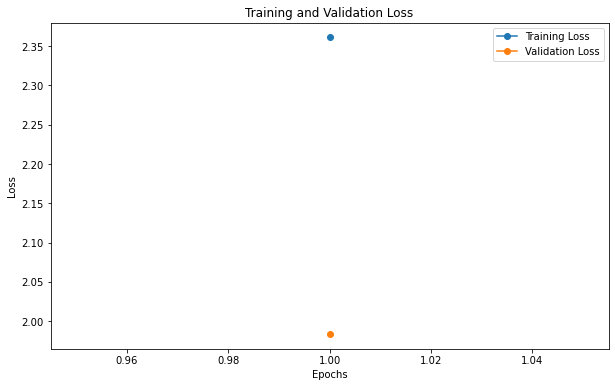

In [135]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
epochs = [1]  # X-axis (epochs)
train_loss = [2.361069]  # Training loss
val_loss = [1.983641]  # Validation loss

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')

# Add labels, title, legend, etc.
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot or save it to a file
plt.show()


In [137]:
model.load_state_dict(torch.load("models/best_BERT.pt")['model'])
model.cpu();

In [153]:
# Read the first 1200 rows from the CSV file
train = pd.read_csv("annotation.csv", sep=',', error_bad_lines=False, nrows=1200)

In [154]:
# Specify the range of rows you want to read (from 1200 to 1500)
start_row = 1201
end_row = 1500

# Calculate the number of rows to read
num_rows_to_read = end_row - start_row

# Read the specified range of rows from the CSV file
val = pd.read_csv("annotation.csv", sep=',', error_bad_lines=False, skiprows=range(1, start_row), nrows=num_rows_to_read)

# Now, the 'train' DataFrame contains rows 1200 to 1500 from the CSV file.


In [158]:
# Assuming your dataframe columns are named 'question' and 'context'
# First, ensure they are in the correct format
train_questions = train['question'].astype(str)
train_contexts = train['context'].astype(str)
val_questions = val['question'].astype(str)
val_contexts = val['context'].astype(str)

In [159]:
# Encode the data with specified max_length
train_encodings = encode_data(tokenizer, train['question'], train['context'], max_length=512)
val_encodings = encode_data(tokenizer, val['question'], val['context'], max_length=512)

In [160]:
add_token_positions(train_encodings, train)
add_token_positions(val_encodings, val)

In [161]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)

In [162]:
start_positions_, end_positions_ = [], []
target_start_positions_, target_end_positions_ = [], []

model.eval()
with torch.no_grad():
    loop = tqdm(val_loader)
    loss_list, count = 0, 0
    for batch in loop:            
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        
        for start in outputs['start_logits'].argmax(dim=1):
            start_positions_.append(start.cpu().item())
        for end in outputs['end_logits'].argmax(dim=1):
            end_positions_.append(end.cpu().item())
            
        for start in start_positions:
            target_start_positions_.append(start.cpu().item())
        for end in end_positions:
            target_end_positions_.append(end.cpu().item())
        

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [08:01<00:00, 16.03s/it]


In [163]:
validation_results = pd.DataFrame({
    "predicted_start_positions": start_positions_,
    "predicted_end_posiitons": end_positions_,
    "target_start_positions": target_start_positions_,
    "target_end_positions": target_end_positions_,
})
# validation_results.to_csv("validation_results.csv", index=False)

In [164]:
from sklearn.metrics import accuracy_score

In [165]:
accuracy_score(validation_results['predicted_start_positions'], validation_results['target_start_positions'])

0.8561872909698997

In [166]:
accuracy_score(validation_results['predicted_end_posiitons'], validation_results['target_end_positions'])

0.8461538461538461